# Aritra MCS202304
## Assignment 5: Transfer Learning (Image)

# Setting up the `environment`

## Downloading necessary libraries

In [ ]:
!pip install -q duckduckgo_search
!pip install -q ipython-autotime

%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00
time: 362 µs (started: 2025-04-19 10:21:05 +00:00)


## Importing libaries

In [ ]:
import os
import random
from urllib.parse import urlparse, unquote
from urllib.request import urlopen

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import requests
from duckduckgo_search import DDGS
from fastcore.all import *
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions

from google.colab import files
import warnings

warnings.filterwarnings('ignore')

time: 9.97 ms (started: 2025-04-19 11:01:15 +00:00)


# Processing `datasets`

## Set up `DuckDuckGoSearch`

In [ ]:
ddgs = DDGS()
def search_images(term, max_images=100):
    keywords = term
    searches = ddgs.images(keywords, term, max_results=max_images)
    images_urls = [item["image"] for item in searches]
    return images_urls

time: 6.26 ms (started: 2025-04-19 10:22:08 +00:00)


In [ ]:
DUCK_FOLDER = 'animals/duck'
CHICKEN_FOLDER = 'animals/chicken'

os.makedirs(DUCK_FOLDER, exist_ok=True)
os.makedirs(CHICKEN_FOLDER, exist_ok=True)

time: 1.6 ms (started: 2025-04-19 10:22:10 +00:00)


In [ ]:
def is_valid_image(image_data):
    """Check if the downloaded data is a valid image"""
    try:
        image = np.asarray(bytearray(image_data), dtype="uint8")
        img = cv2.imdecode(image, cv2.IMREAD_COLOR)
        return img is not None
    except:
        return False

time: 757 µs (started: 2025-04-19 10:22:24 +00:00)


In [ ]:
def get_file_extension_from_url(url):
    """Extract the file extension from a URL, handling query parameters and encoded characters."""
    parsed = urlparse(unquote(url))

    path = parsed.path

    parts = path.split('/')
    filename = parts[-1] if parts else ""

    if '.' in filename:
        ext = filename.rsplit('.', 1)[-1].lower()
        ext = ext.split('?')[0].split('#')[0]
        if ext.lower() in ['jpg', 'jpeg', 'png', 'gif', 'webp']:
            return ext
    return 'jpg'

time: 1.09 ms (started: 2025-04-19 10:22:33 +00:00)


## Downloading `images`

In [ ]:
def download_images(image_urls, directory):
    """Download images from a list of URLs and save them to the specified directory."""
    image_id = 1
    for url in image_urls:
        if image_id > 100:
            break
        try:
            response = requests.get(url)
            response.raise_for_status()
            if not is_valid_image(response.content):
              print(f"Invalid image: {url}")
            file_ext = get_file_extension_from_url(url)
            filename = f'image_{image_id}.{file_ext}'
            file_path = os.path.join(f'animals/{directory}', filename)
            with open(file_path, 'wb') as f:
                f.write(response.content)
            image_id += 1
            print(f'Downloaded: {file_path}')
        except Exception as e:
            print(f'Failed to download {url}: {e}')

time: 878 µs (started: 2025-04-19 10:22:36 +00:00)


In [ ]:
# The 2nd entry in each element denotes the keyword to search in the duckduckgo
targets = [['duck', 'Single duck in nature'], ['chicken', 'Single hen in nature']]

for target in targets:
    directory, keyword = target
    image_urls = search_images(keyword, max_images=200)
    download_images(image_urls, directory)

Failed to download https://static.vecteezy.com/system/resources/previews/046/648/669/large_2x/an-image-of-a-single-duck-swimming-on-a-pond-with-water-ripples-photo.jpg: 403 Client Error: Forbidden for url: https://static.vecteezy.com/system/resources/previews/046/648/669/large_2x/an-image-of-a-single-duck-swimming-on-a-pond-with-water-ripples-photo.jpg
Downloaded: animals/duck/image_1.jpg
Downloaded: animals/duck/image_2.jpg
Downloaded: animals/duck/image_3.jpg
Downloaded: animals/duck/image_4.jpg
Downloaded: animals/duck/image_5.jpg
Downloaded: animals/duck/image_6.jpg
Downloaded: animals/duck/image_7.jpg
Downloaded: animals/duck/image_8.jpg
Downloaded: animals/duck/image_9.jpg
Downloaded: animals/duck/image_10.jpg
Downloaded: animals/duck/image_11.jpg
Downloaded: animals/duck/image_12.jpg
Downloaded: animals/duck/image_13.jpg
Downloaded: animals/duck/image_14.jpg
Downloaded: animals/duck/image_15.jpg
Downloaded: animals/duck/image_16.jpg
Downloaded: animals/duck/image_17.jpg
Download

## Preprocessing `images`

In [ ]:
def load_and_preprocess_images(directory, target_size=(224, 224)):
    """Load and preprocess images from a directory."""
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        class_label = class_names.index(class_name)

        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            try:
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, target_size)
                    image = image.astype('float32') / 255.0
                    images.append(image)
                    labels.append(class_label)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                continue

    return np.array(images), np.array(labels)

images, labels = load_and_preprocess_images('animals')

time: 5.86 s (started: 2025-04-19 10:24:10 +00:00)


## Plot random images

In [ ]:
def plot_random_images(images, labels, class_names, num_images=24):
    """Plot a specified number of random images from the dataset."""
    indices = random.sample(range(len(images)), num_images)
    selected_images = images[indices]
    selected_labels = labels[indices]

    plt.figure(figsize=(15, 6))

    for i in range(num_images):
        plt.subplot(4, 6, i + 1)
        plt.imshow(selected_images[i])
        plt.title(class_names[selected_labels[i]], fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

time: 705 µs (started: 2025-04-19 10:24:16 +00:00)


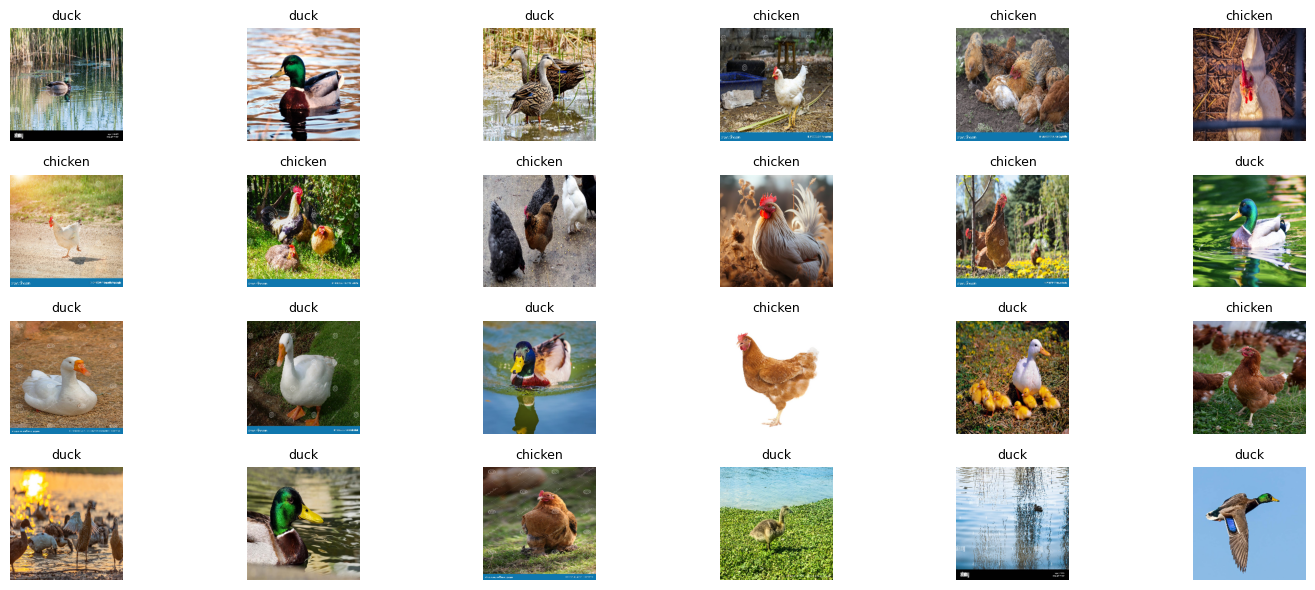

time: 1.6 s (started: 2025-04-19 10:24:20 +00:00)


In [ ]:
class_names = sorted(os.listdir('animals'))
plot_random_images(images, labels, class_names)

## Split into `Train` and `Test`

In [ ]:
X, y = images, labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

time: 305 ms (started: 2025-04-19 11:47:37 +00:00)


# Compiling the model

## Visualize the performance of the base model: `MobileNetV2`

In [ ]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...] # Need to have input shape (None, 224, 224, 3)
    return image

time: 543 µs (started: 2025-04-19 11:34:59 +00:00)


In [ ]:
def get_random_images(folder, num=5):
    all_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    return random.sample(all_images, min(num, len(all_images)))

time: 679 µs (started: 2025-04-19 11:35:00 +00:00)


### Setting up the `MobileNetV2`

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

time: 1.07 s (started: 2025-04-19 13:30:04 +00:00)


In [ ]:
def process_and_predict(image_path):
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw)
    image = preprocess(image)

    preds = base_model.predict(image)
    decoded = decode_predictions(preds, top=5)[0]

    return image, decoded

time: 636 µs (started: 2025-04-19 11:35:00 +00:00)


In [ ]:
def show_results(image_path, predictions, class_name):
    original_img = plt.imread(image_path)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(class_name)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.5, "\n".join(
        [f"{i+1}: {label} ({prob:.2%})"
         for i, (_, label, prob) in enumerate(predictions)]
    ), fontsize=12)
    plt.axis('off')
    plt.title("MobileNetV2 predictions")
    plt.show()

time: 1.23 ms (started: 2025-04-19 11:35:06 +00:00)


### Showing some sample classification for the `base model`

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


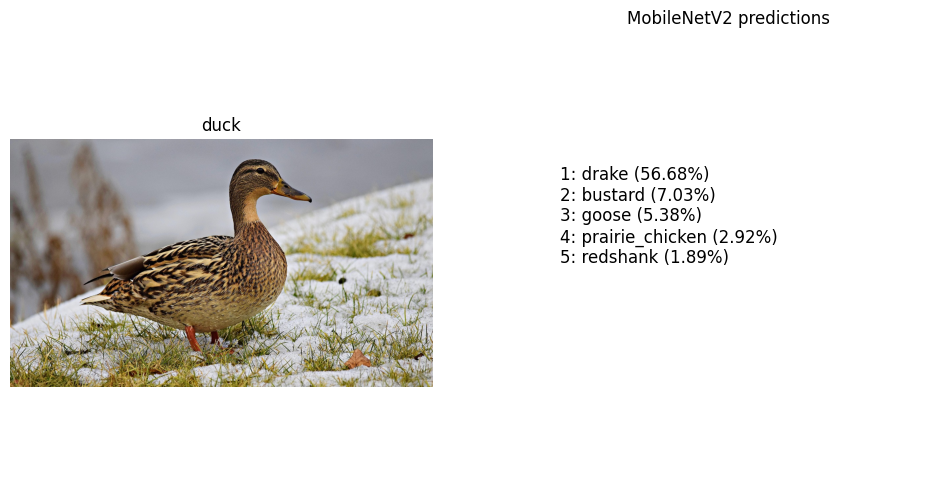

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


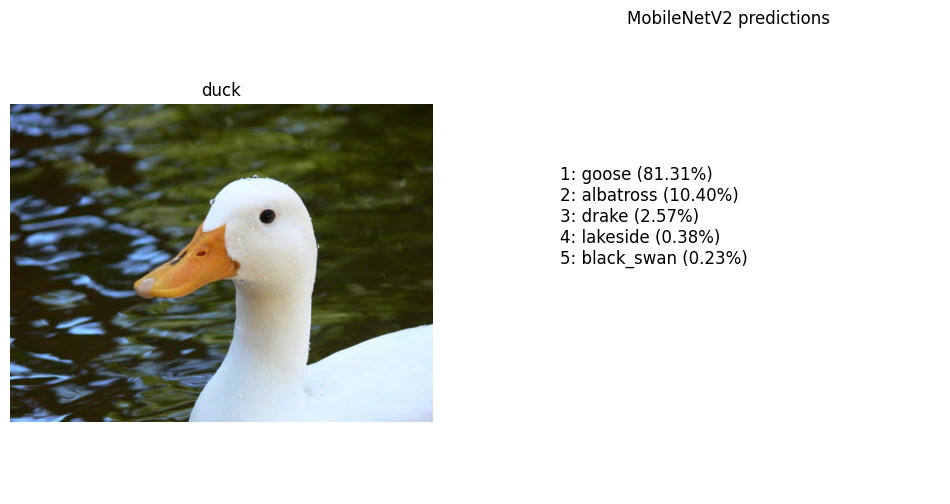

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


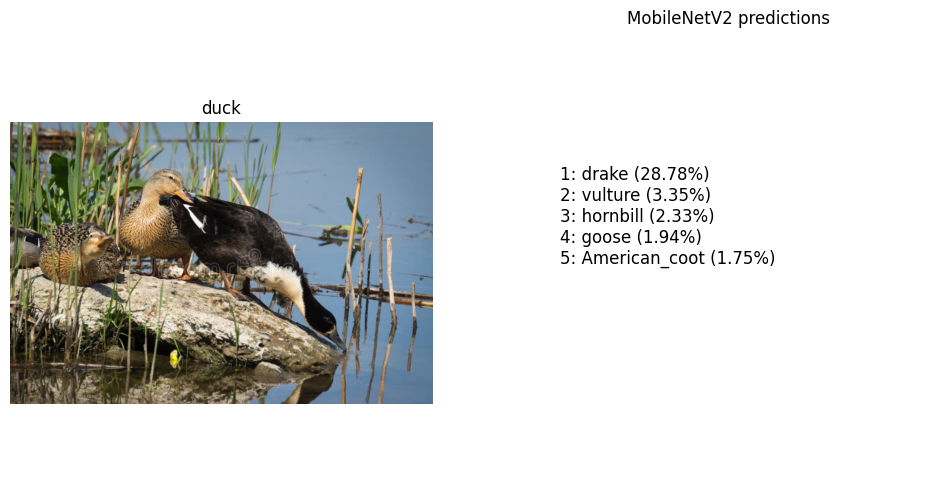

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


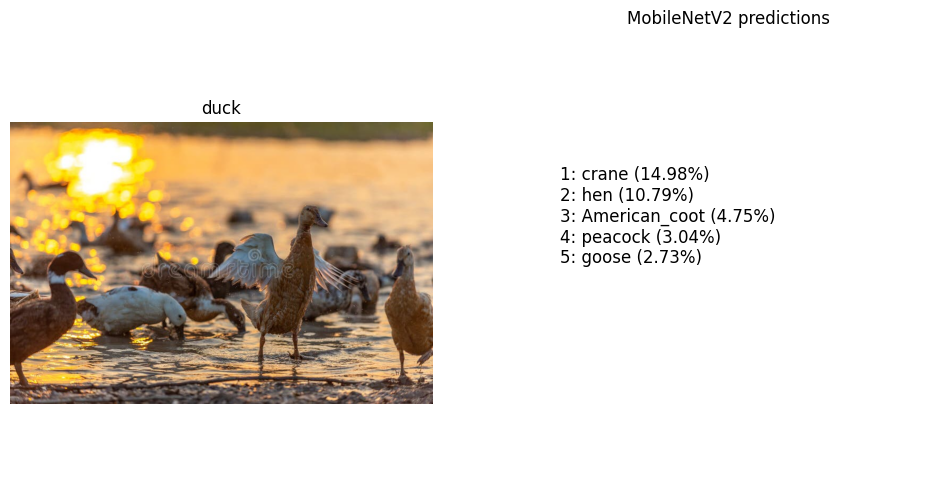

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


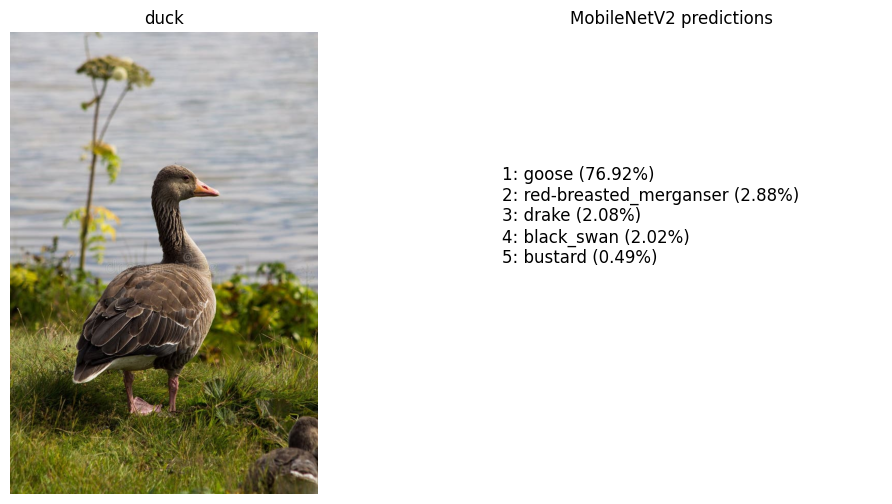

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


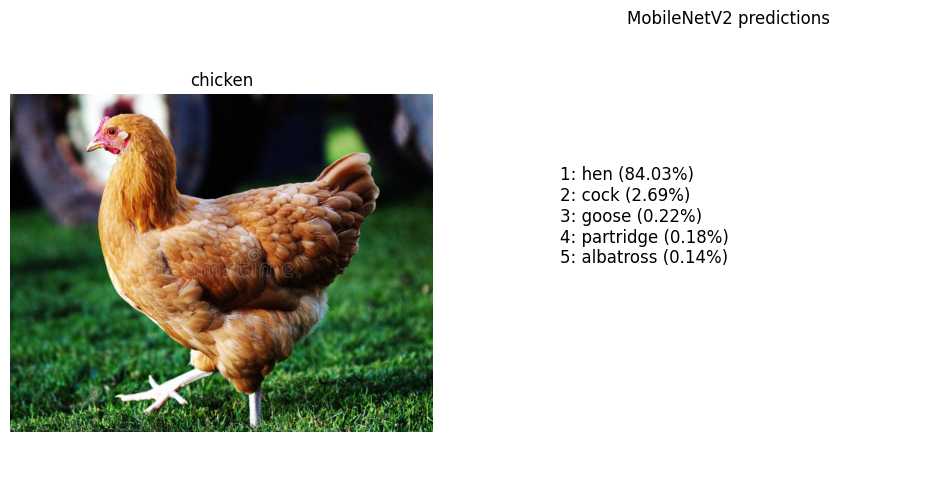

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


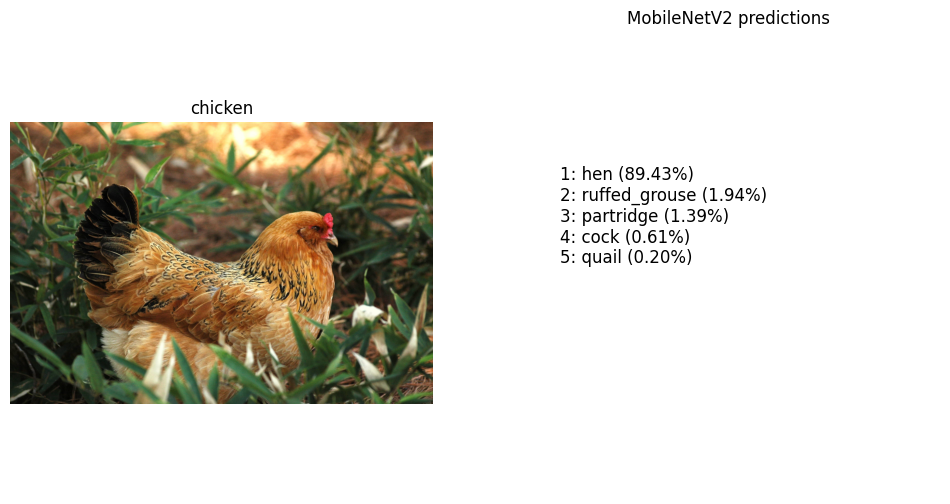

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


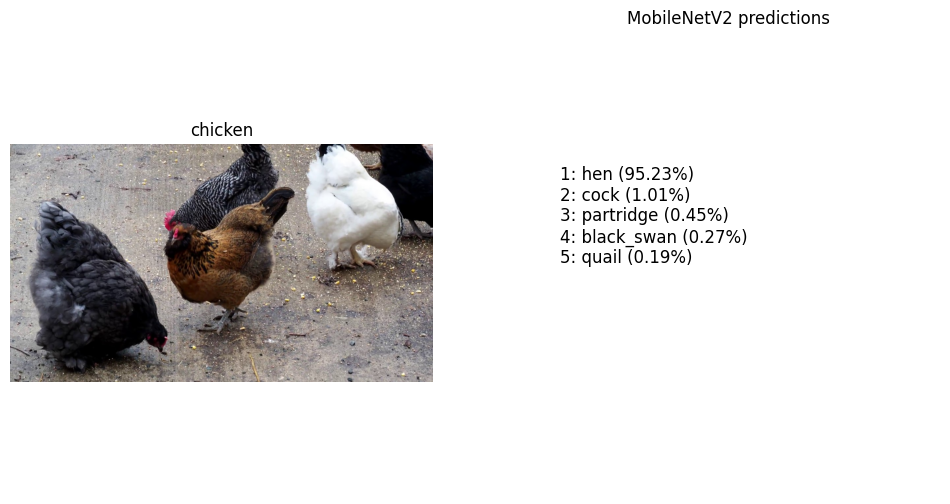

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


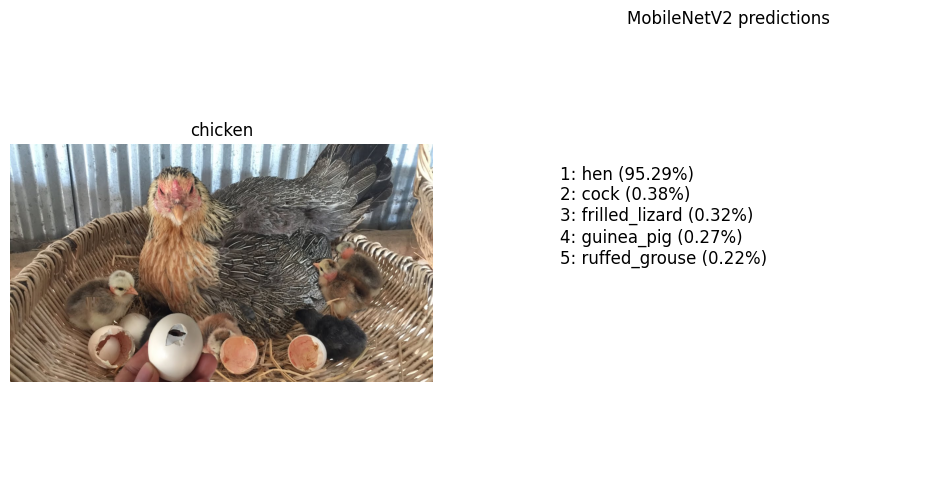

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


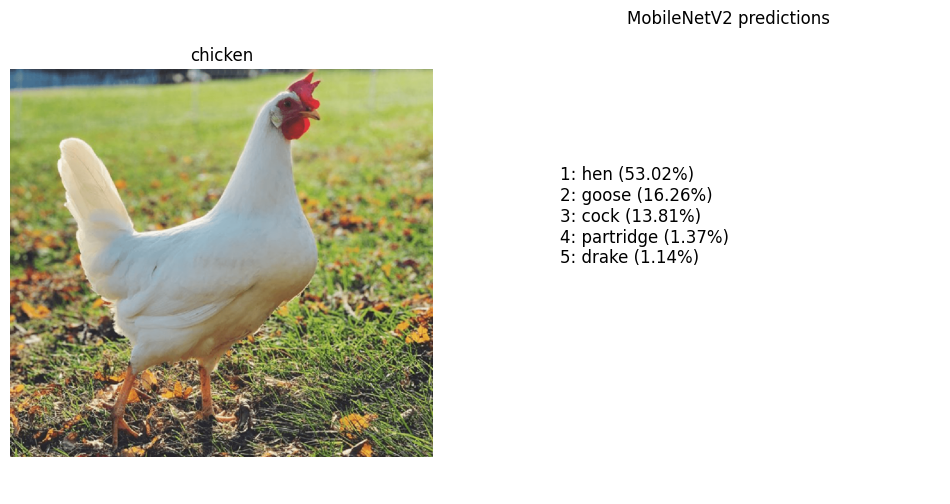

time: 6.23 s (started: 2025-04-19 11:16:42 +00:00)


In [ ]:
duck_images = get_random_images(DUCK_FOLDER)
chicken_images = get_random_images(CHICKEN_FOLDER)

for img_path in duck_images:
    _, preds = process_and_predict(img_path)
    show_results(img_path, preds, "duck")

for img_path in chicken_images:
    _, preds = process_and_predict(img_path)
    show_results(img_path, preds, "chicken")

## Adding the `classfication head`

 - Setting `include_top` to `False` tells the model to exclude the final classification layers (the "top" of the network).
 - We are doing it because we will add a new classification head

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

print(len(base_model.layers))

154
time: 881 ms (started: 2025-04-19 11:50:07 +00:00)


In [ ]:
base_model.trainable = False

# Note that, there are total 154 layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

time: 30.7 ms (started: 2025-04-19 11:50:10 +00:00)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

time: 7.4 ms (started: 2025-04-19 11:50:12 +00:00)


## Enable `early-stopping` and train the model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5974 - loss: 0.6694 - val_accuracy: 0.7750 - val_loss: 0.5620
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6391 - loss: 0.6339 - val_accuracy: 0.8250 - val_loss: 0.4591
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7051 - loss: 0.5701 - val_accuracy: 0.9000 - val_loss: 0.3805
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7800 - loss: 0.4609 - val_accuracy: 0.9250 - val_loss: 0.3146
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8771 - loss: 0.3682 - val_accuracy: 0.9750 - val_loss: 0.2626
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8848 - loss: 0.3682 - val_accuracy: 0.9750 - val_loss: 0.2241
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9161 - loss: 0.2907 - val_accuracy: 0.9750 - val_loss: 0.1938
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8694 - loss: 0.3315 - val_accuracy: 0.9750 - val_loss: 0.1701
Epoch 9/

## Summarizing the model

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)

time: 81.8 ms (started: 2025-04-19 12:43:54 +00:00)


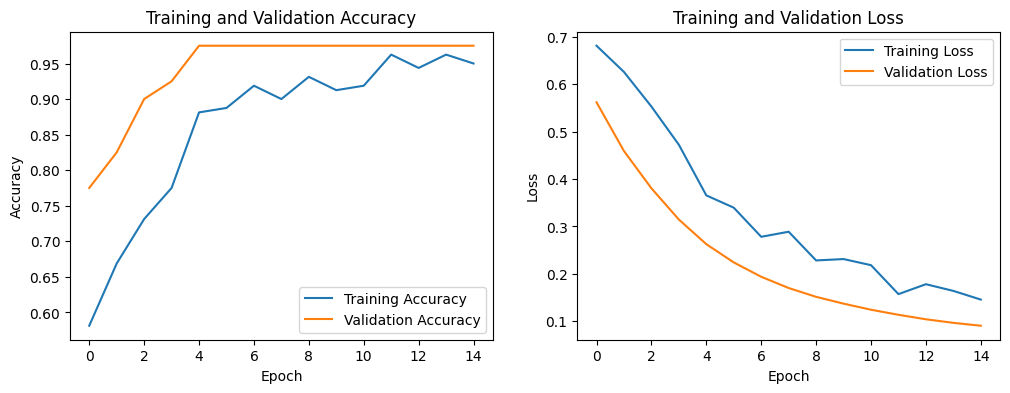

time: 886 ms (started: 2025-04-19 12:47:28 +00:00)


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Unfreezing the last few layers of the `base_model`

- Keep the first 100 layers freezed.

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

time: 32.8 ms (started: 2025-04-19 11:56:23 +00:00)


In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.9742 - loss: 0.1295 - val_accuracy: 0.9750 - val_loss: 0.0899
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9864 - loss: 0.1413 - val_accuracy: 0.9750 - val_loss: 0.0889
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9623 - loss: 0.1210 - val_accuracy: 0.9750 - val_loss: 0.0878
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9589 - loss: 0.1372 - val_accuracy: 0.9750 - val_loss: 0.0869
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9503 - loss: 0.1559 - val_accuracy: 0.9750 - val_loss: 0.0860
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9722 - loss: 0.1245 - val_accuracy: 0.9750 - val_loss: 0.0851
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9753 - loss: 0.1408 - val_accuracy: 0.9750 - val_loss: 0.0843
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9584 - loss: 0.1101 - val_accuracy: 0.9750 - val_loss: 0.0836
Epoch 9/

### Why is `training accuracy` lower than `val accuracy`?
Dropout layers are "on" in training, but they will be turned "off" (skipped) when doing validation and testing. This is automatic and it is by design. Dropout harms training error slightly. This is to be expected. Dropout layers are actually helpful in deep neural nets for regularization despite the additional training challenges. Most deep neural nets probably use dropout.

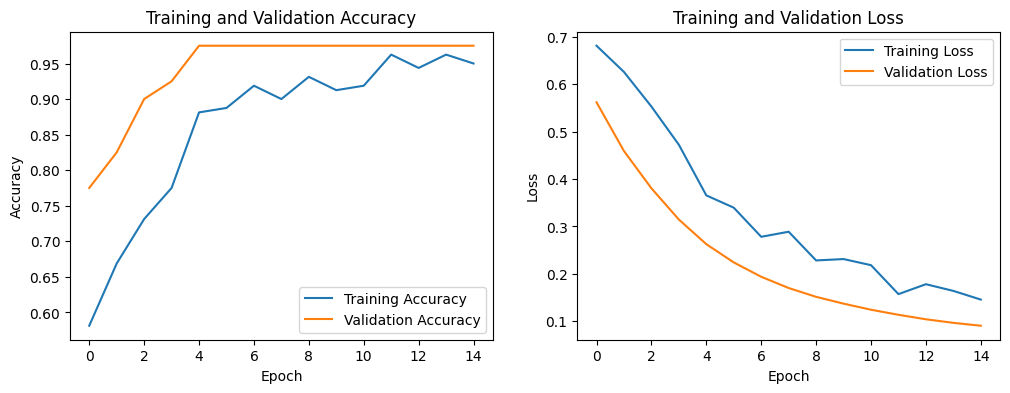

time: 3.39 s (started: 2025-04-19 12:05:14 +00:00)


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Classfication Report

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype('int')

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['chicken', 'duck']))

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step

Classification Report:
              precision    recall  f1-score   support

     chicken       1.00      0.95      0.98        21
        duck       0.95      1.00      0.97        19

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40

time: 5.23 s (started: 2025-04-19 12:00:49 +00:00)


# Classifying some images

## Plotting some `classificaion instances`

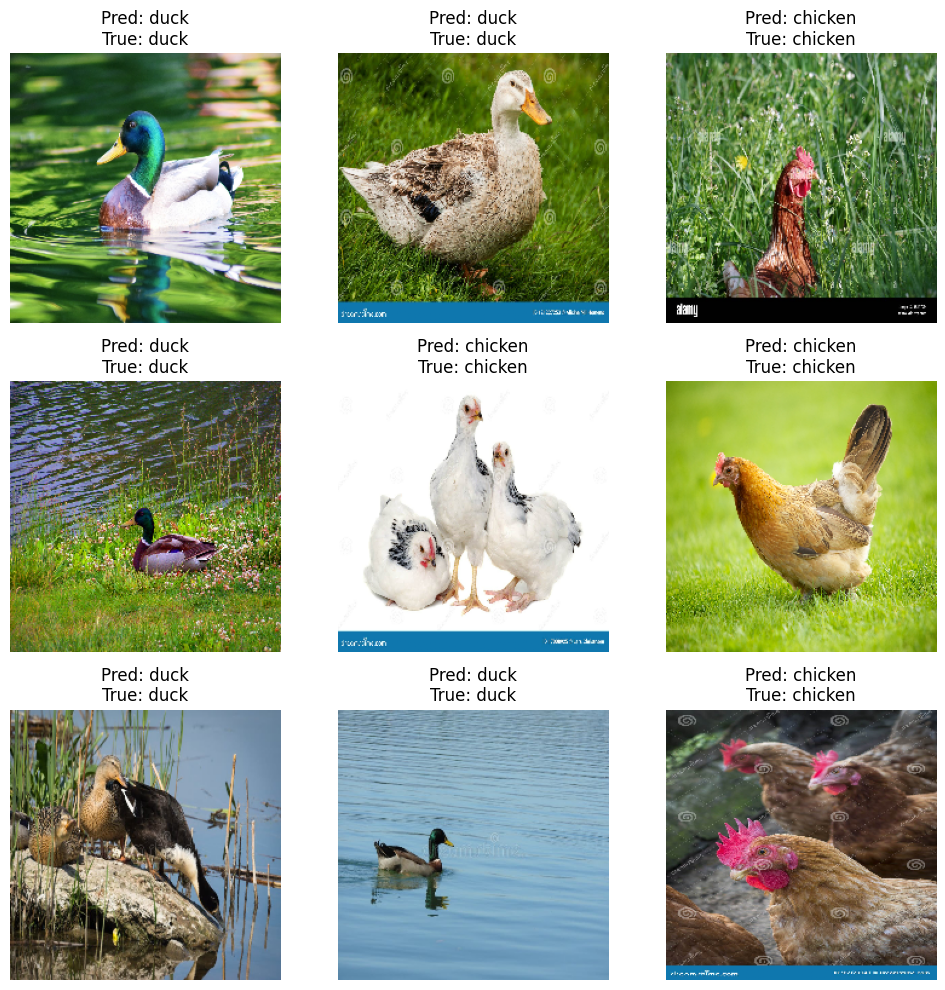

time: 1 s (started: 2025-04-19 12:05:22 +00:00)


In [ ]:
plt.figure(figsize=(10, 10))

random_indices = np.random.choice(len(X_test), size=9, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[idx])
    pred_label = 'duck' if y_pred_classes[idx] == 1 else 'chicken'
    true_label = 'duck' if y_test[idx] == 1 else 'chicken'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Plotting some of the images where the `classifier` is wrong

In [ ]:
def flatten_array(arr):
  return np.concatenate(arr)

y_pred_flattened = flatten_array(y_pred_classes)

time: 780 µs (started: 2025-04-19 12:55:13 +00:00)


In [ ]:
incorrect_indices = np.where(y_pred_flattened != y_test)

time: 424 µs (started: 2025-04-19 12:55:15 +00:00)



Found 1 incorrect prediction(s). Showing them:



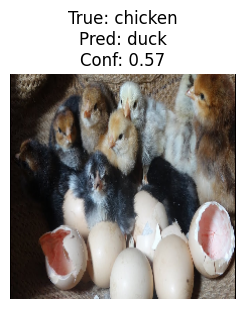

time: 413 ms (started: 2025-04-19 12:56:04 +00:00)


In [ ]:
print(f"\nFound {len(incorrect_indices)} incorrect prediction(s). Showing them:\n")

plt.figure(figsize=(12, 8))
for i, idx in enumerate(incorrect_indices[0]):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[idx])

    pred_label = 'duck' if y_pred_classes[idx] == 1 else 'chicken'
    true_label = 'duck' if y_test[idx] == 1 else 'chicken'
    confidence = y_pred[idx][0] if y_pred_classes[idx] == 1 else 1 - y_pred[idx][0]

    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()